In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import datetime
from collections import Counter
from tqdm import tqdm_notebook as tqdm

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold, StratifiedKFold
import gc

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/data-science-bowl-2019/train.csv
/kaggle/input/data-science-bowl-2019/specs.csv
/kaggle/input/data-science-bowl-2019/train_labels.csv
/kaggle/input/data-science-bowl-2019/test.csv
/kaggle/input/data-science-bowl-2019/sample_submission.csv


In [2]:
train = pd.read_csv('../input/data-science-bowl-2019/train.csv')
train_labels = pd.read_csv('../input/data-science-bowl-2019/train_labels.csv')
test = pd.read_csv('../input/data-science-bowl-2019/test.csv')
specs = pd.read_csv('../input/data-science-bowl-2019/specs.csv')
sample_submission = pd.read_csv('../input/data-science-bowl-2019/sample_submission.csv')

In [3]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [4]:
train.shape

(11341042, 11)

In [5]:
# Since not all installation_ids in the training set have taken the assessments whereas every installation_id in the test set
# has attempted at least one assessment, installation_ids without assessments will be removed

keep_id = train[train.type == 'Assessment'][['installation_id']].drop_duplicates()
train = pd.merge(train, keep_id, on='installation_id', how='inner')


In [6]:
# installation_ids now reduced by 3 million entries
train.shape

(8294138, 11)

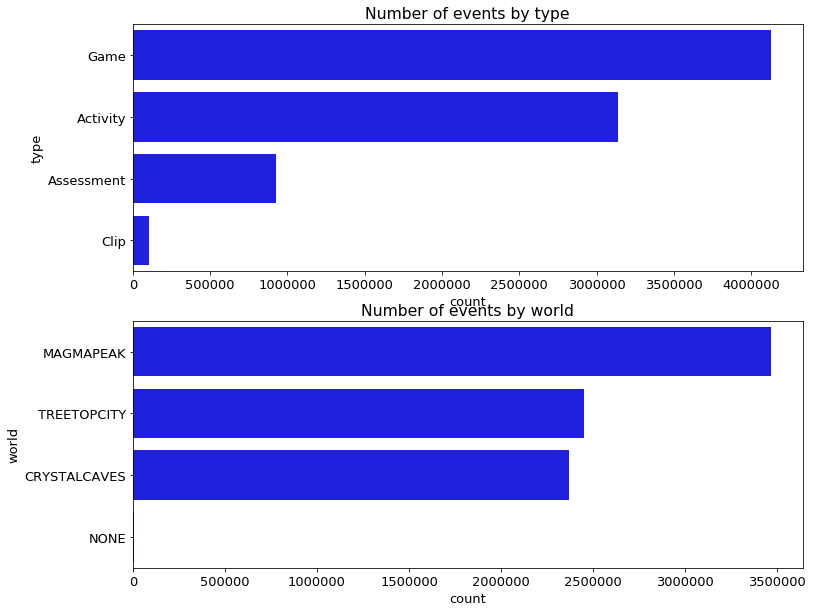

In [7]:
# Visualizing the train dataset
plt.rcParams.update({'font.size': 13})

fig = plt.figure(figsize = (12, 10))
ax1 = fig.add_subplot(211)
ax1 = sns.countplot(y = 'type', data = train, color = 'blue',
                   order = train.type.value_counts().index)
plt.title("Number of events by type")

ax2 = fig.add_subplot(212)
ax2 = sns.countplot(y = 'world', data = train, color = 'blue',
                   order = train.world.value_counts().index)
plt.title("Number of events by world")

plt.show()

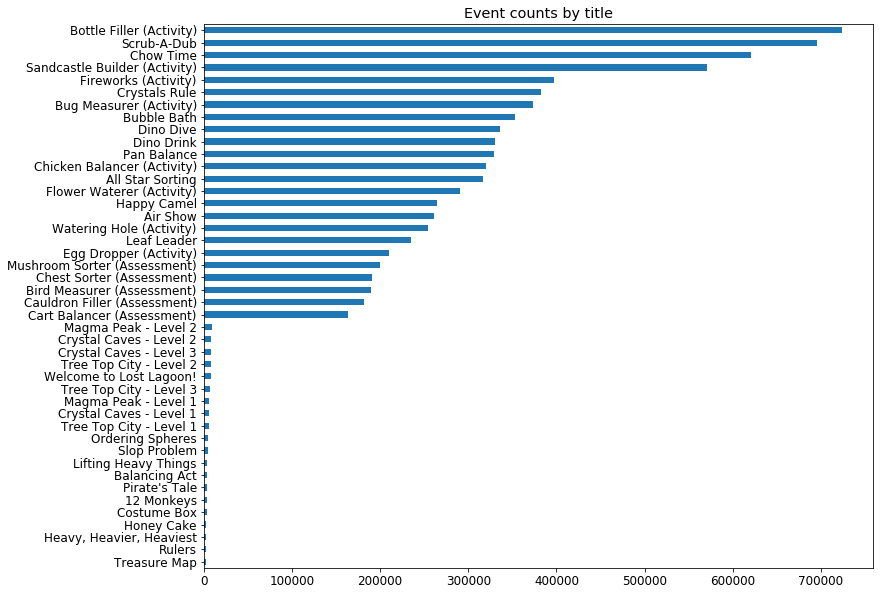

In [8]:
plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize  = (12,10))
se = train.title.value_counts().sort_values(ascending = True)
se.plot.barh()
plt.title("Event counts by title")
plt.show()

In [9]:
# Adding some time based columns for the timestamp and visualizing these

def get_time(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    return df

train = get_time(train)

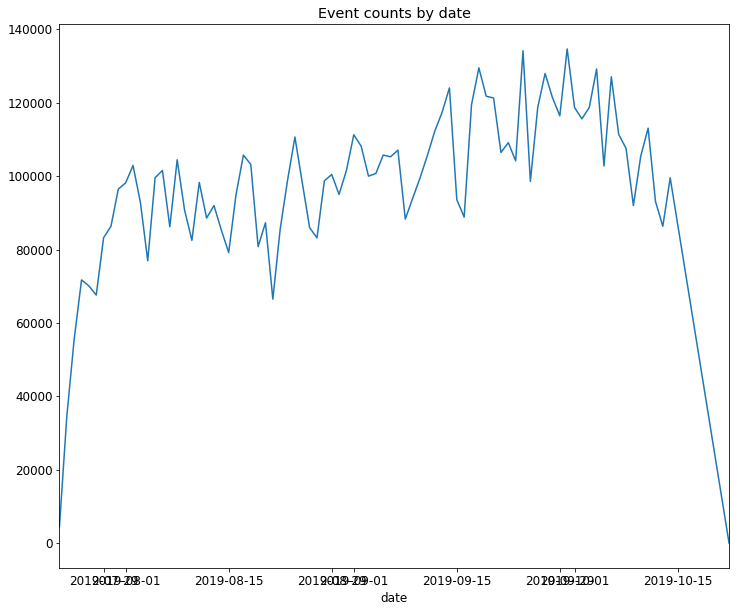

In [10]:
# Counts for date

fig = plt.figure(figsize = (12,10))
se = train.groupby('date')['date'].count()
se.plot()
plt.title("Event counts by date")
plt.show()

In [11]:
# Understanding the test set
test.head()


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [12]:
test.shape

(1156414, 11)

In [13]:
test.installation_id.nunique()

1000

In [14]:
# Test data has 11 million rows with 1000 unique installation ids which is the
# same as the sample_submission, so there are no installation ids without an 
# assessment in the test set

sample_submission.shape

(1000, 2)

In [15]:
# Checking date ranges for the data

test['timestamp'] = pd.to_datetime(test['timestamp'])
print(f'The date range in train is: {train.timestamp.dt.date.min()} to {train.timestamp.dt.date.max()}')
print(f'The date range in test is: {test.timestamp.dt.date.min()} to {test.timestamp.dt.date.max()}')

# Both train and test data seems to come from similar date ranges which suggest 
# a dataset that was split randomly into train and test sets

The date range in train is: 2019-07-23 to 2019-10-22
The date range in test is: 2019-07-24 to 2019-10-14


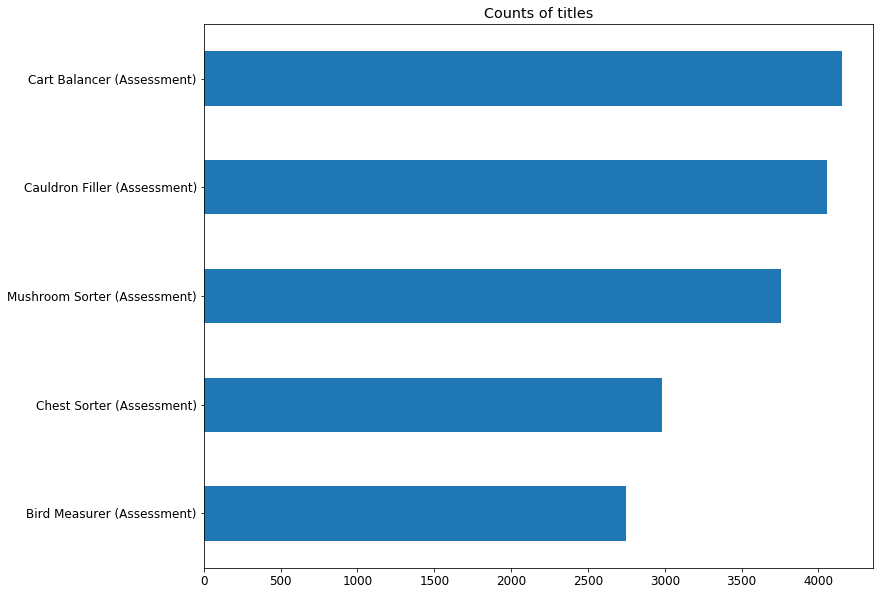

In [16]:
# Understanding and visualizing the train labels data

fig = plt.figure(figsize = (12,10))
se = train_labels.title.value_counts().sort_values(ascending = True)
se.plot.barh()
plt.title("Counts of titles")
plt.show()


In [17]:
# Understanding the train_labels data
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [18]:
train_labels.shape

(17690, 7)

In [19]:
train_labels.installation_id.nunique()

3614

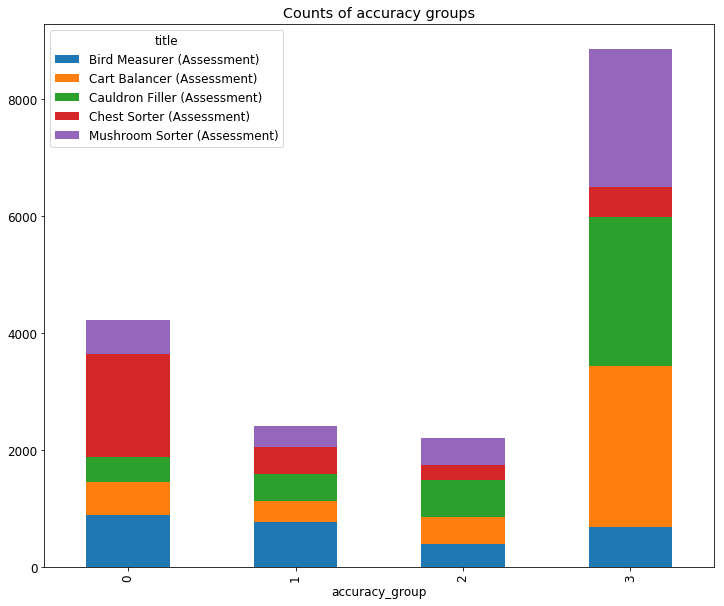

In [20]:
# Visualizing different accuracy groups and the titles within

se = train_labels.groupby(['title', 'accuracy_group'])['accuracy_group'].count().unstack('title')
se.plot.bar(stacked = True, figsize = (12,10))
plt.title("Counts of accuracy groups")
plt.show()

In [21]:
# Since we have already taken out installation ids that has no assesments,
# lets check if they are installation ids with assessments that aren't
# included in the train labels data

train[~train.installation_id.isin(train_labels.installation_id.unique())].installation_id.nunique()

628

In [22]:
# Since those 628 unique installation ids are not included in the train labels 
# data, we have no information of their accuracy groups. Hence we shall remove them

train = train[train.installation_id.isin(train_labels.installation_id.unique())]
train.shape

# Train set further reduced to 7.7 million rows

(7734558, 15)

In [23]:
# Checking if game session is the unique identifier in train_labels
print(f'Number of rows in train_labels: {train_labels.shape[0]}')
print(f'Number of unique game_sessions in train_labels: {train_labels.game_session.nunique()})')

Number of rows in train_labels: 17690
Number of unique game_sessions in train_labels: 17690)


In [24]:
# Feature Engineering
train = train.drop(['date', 'month', 'hour', 'dayofweek'], axis = 1)

In [25]:
# Creating a function to encode all categorical data

def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '-' + str(y),
                                        train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '-' + str(y),
                                       test['title'], test['event_code']))
    all_title_event_code = list(set(train['title_event_code'].unique()).union(test['title_event_code'].unique()))
    
    # make a list with all the unique titles from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    
    # make a list with all the unique event_code from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))

    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    
    # replace the text titles with the number titles form the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    
    # set the 'Bird Measurer (Assessment)' as 4110
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

# get useful dict with maping encode
train, test, train_labels, win_code, list_of_user_activities,list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)

categoricals = ['session_title']


In [26]:
# convert raw data to processed features

def get_data(user_sample, test_set = False):
    '''
    The user_sample is a DataFrame from train or test where the only one installaion_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered if test_set = False
    '''
    # constants and parameters declaration
    last_activity = 0
    user_activities_count = {'Clip': 0, 'Activity': 0, 'Assessment': 0, 'Game': 0}
    
    # news features: time spent in each activity
    time_spent_each_act = {actv: 0 for actv in list_of_user_activities}
    event_code_count = {eve: 0 for eve in list_of_event_code}
    last_session_time_sec = 0
    
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    
    # iterate through each session of one installation_id
    for i, session in user_sample.groupby('game_session', sort = False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session

        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]

        # get current session time in seconds
        if session_type != 'Assessment':
            time_spent = int(session['game_time'].iloc[-1] / 1000)
            time_spent_each_act[activities_labels[session_title]] += time_spent

        # for each assessment, and only this kind of session, the features below are processed and a register is generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event code 4100 that represents the assessment trials
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then check the number of wins and number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it is initialized with some items:
            # {'Clip': 0, 'Activity': 0, 'Assessment': 0, 'Game': 0}
            features = user_activities_count.copy()
            features.update(time_spent_each_act.copy())
            features.update(event_code_count.copy())
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # add the feature of the history of the trials of this player
            # this is based on all the attempts so far at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0,2]).seconds)
            # the accuracy is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts + false_attempts) if (true_attempts + false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this plater was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions

            # there are some conditions to allow this features to be inserted in the dataset
            # if it is a test set, all session belong to the final dataset
            # if it is a train set, needs to be passed through this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts + false_attempts > 0:
                all_assessments.append(features)

            counter += 1
    
        # this piece counts how many actions were made in each event_code so far
        n_of_event_codes = Counter(session['event_code'])

        for key in n_of_event_codes.keys():
            event_code_count[key] += n_of_event_codes[key]

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activity = session_type

    # if test_set = True, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in train_set, all assessments are kept
    return all_assessments


In [27]:
# applying the function to each installation_id in the train dataset

compiled_data = []

for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), 
                                    total = train.installation_id.nunique(), desc = 'Installation_id', position = 0):
    compiled_data += get_data(user_sample)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [28]:
# compiled data is converted into DataFrame and deleted to reduce memory
reduce_train = pd.DataFrame(compiled_data)
del compiled_data
reduce_train.shape

(17690, 103)

In [29]:
reduce_train.head()

,Clip,Activity,Assessment,Game,Rulers,Bottle Filler (Activity),Flower Waterer (Activity),Watering Hole (Activity),Slop Problem,Bird Measurer (Assessment),...,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,accuracy_group,0,1,2,3,accumulated_accuracy_group,accumulated_actions
0,6,3,0,2,0,0,164,0,0,0,...,0,0.00,0.0,3,0,0,0,0,0.0,647
1,8,4,1,4,0,0,164,0,0,0,...,0,39.00,1.0,0,0,0,0,1,3.0,1143
2,8,4,2,4,0,0,164,0,0,0,...,11,65.50,0.5,3,1,0,0,1,1.5,1230
3,15,9,3,7,0,165,254,80,0,0,...,11,41.25,0.5,2,2,0,0,2,1.5,2159
4,17,10,3,9,0,165,254,80,0,0,...,12,39.20,0.5,3,2,0,1,2,1.6,2586


In [30]:
# doing the same thing to the test set
new_test = []
for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = test.installation_id.nunique(), desc = 'Installation_id', position = 0):
    a = get_data(user_sample, test_set = True)
    new_test.append(a)

reduce_test = pd.DataFrame(new_test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
reduce_test.shape

(1000, 103)

In [32]:
reduce_test.head()

,Clip,Activity,Assessment,Game,Rulers,Bottle Filler (Activity),Flower Waterer (Activity),Watering Hole (Activity),Slop Problem,Bird Measurer (Assessment),...,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,accuracy_group,0,1,2,3,accumulated_accuracy_group,accumulated_actions
0,5,3,1,3,0,0,0,0,0,0,...,0,30.0,1.000000,0,0,0,0,1,3.0,867
1,16,11,5,11,0,348,178,73,0,0,...,7,49.6,0.466667,0,1,1,2,1,1.6,2718
2,2,2,0,0,0,0,51,0,0,0,...,0,0.0,0.000000,0,0,0,0,0,0.0,149
3,4,2,0,1,0,0,85,0,0,0,...,0,0.0,0.000000,0,0,0,0,0,0.0,233
4,5,1,0,4,0,0,0,0,0,0,...,0,0.0,0.000000,0,0,0,0,0,0.0,951


In [33]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [34]:
def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

In [35]:
def run_feature_selection(reduce_train, reduce_test, usefull_features, new_features):
    kf = StratifiedKFold(n_splits = 10, shuffle = True)
    target = 'accuracy_group'
    oof_pred = np.zeros((len(reduce_train), 4))
    for fold, (tr_ind, val_ind) in enumerate(kf.split(reduce_train, reduce_train[target])):
        print('Fold {}'.format(fold + 1))
        x_train, x_val = reduce_train[usefull_features].iloc[tr_ind], reduce_train[usefull_features].iloc[val_ind]
        y_train, y_val = reduce_train[target][tr_ind], reduce_train[target][val_ind]
        train_set = lgb.Dataset(x_train, y_train, categorical_feature = categoricals)
        
        params = {
            'learning_rate': 0.01,
            'metric' : 'multiclass',
            'objective' : 'multiclass',
            'num_classes' : 4,
            'feature_fraction' : 0.75,
            'subsample' : 0.75,
            'n_jobs' : -1,
            'seed' : 50,
            'max_depth' : 10
        }
        
        model = lgb.train(params, train_set, num_boost_round = 100000, early_stopping_rounds = 100, valid_sets = [train_set, val_set], verbose_eval = 500)
        oof_pred[val_ind] = model.predict(x_val)
        # using cohem kappa because its the evaluation metric of the competition
        loss_score = cohen_kappa_score(reduce_train[target], np.argmax(oof_pred, axis = 1), weights = 'quadratic')
        score = loss_score
        usefull_new_features = []
        for i in new_features:
            oof_pred = np.zeros((len(reduce_train), 4))
            evaluating_features = usefull_features + usefull_new_features + [i]
            print('Evaluating {} column'.format(i))
            print('Our best cohen kappa score is : {}'.format(score))
            for fold, (tr_ind, val_ind) in enumerate(kf.split(reduce_train, reduce_train[target])):
                print('Fold {}'.format(fold + 1))
                x_train, x_val = reduce_train[evaluating_features].iloc[tr_ind], reduce_train[evaluating_features].iloc[val_ind]
                y_train, y_val = reduce_train[target][tr_ind], reduce_train[target][val_ind]
                train_set = lgb.Dataset(x_train, y_train, categorical_feature = categoricals)
                val_set = lgb.Dataset(x_val, y_val, categorical_feature = categoricals)
                model = lgb.train(params,train_set, num_boost_round = 100000, early_stopping_rounds = 100, valid_sets = [train_set, val_set], verbose_eval = 500)
                oof_pred[val_ind] = model.predict(x_val)
            loss_score = cohen_kappa_score(reduce_train[target], np.argmax(oof_pred, axis = 1), weights = 'quadratic')
            print('Our new cohen kappa score is : {}'.format(loss_score))
            if loss_score > score:
                print('Feature {} is usefull, adding feature to usefull_new_feature_list'.format(i))
                usefull_new_features.append(i)
                score = loss_score
            else:
                print('Feature {} is not usefull'.format(i))
            gc.collect
        print('The best features are: ' , usefull_new_features)
        print('Our best cohen kappa score is : ', score)
        
        return usefull_features + usefull_new_features

In [36]:
def run_lgb_regression(reduce_train, reduce_test, usefull_features, n_splits):
    kf = StratifiedKFold(n_splits = n_splits, shuffle = True)
    target = 'accuracy_group'
    oof_pred = np.zeros((len(reduce_train), ))
    y_pred = np.zeros((len(reduce_test), ))
    for fold, (tr_ind, val_ind) in enumerate(kf.split(reduce_train, reduce_train[target])):
        print('Fold {}'.format(fold + 1))
        x_train, x_val = reduce_train[usefull_features].iloc[tr_ind], reduce_train[usefull_features].iloc[val_ind]
        y_train, y_val = reduce_train[target][tr_ind], reduce_train[target][val_ind]
        train_set = lgb.Dataset(x_train, y_train, categorical_feature = categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature = categoricals)
        
        params = {
            'n_estimators': 5000,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.01,
            'feature_fraction': 0.9,
            'max_depth': 15,
            'lambda_l1': 1,
            'lambda_l2': 1,
            'verbose': 100,
            'early_stopping_rounds': 100
        }
        
        model = lgb.train(params, train_set, num_boost_round = 1000000, early_stopping_rounds = 300, valid_sets = [train_set, val_set], verbose_eval = 100)
        oof_pred[val_ind] = model.predict(x_val)
        y_pred += model.predict(reduce_test[usefull_features]) / n_splits
    _, loss_score, _ = eval_qwk_lgb_regr(reduce_train[target], oof_pred)
    print('Our oof cohen kappa score is: ' , loss_score)
    
    return y_pred

In [37]:
def run_xgb_regression(reduce_train, reduce_test, usefull_features, n_splits):
    kf = StratifiedKFold(n_splits = n_splits, shuffle = True)
    target = 'accuracy_group'
    oof_pred = np.zeros((len(reduce_train), ))
    y_pred = np.zeros((len(reduce_test), ))
    for fold, (tr_ind, val_ind) in enumerate(kf.split(reduce_train, reduce_train[target])):
        print('Fold {}'.format(fold + 1))
        x_train, x_val = reduce_train[usefull_features].iloc[tr_ind], reduce_train[usefull_features].iloc[val_ind]
        y_train, y_val = reduce_train[target][tr_ind], reduce_train[target][val_ind]
        xgb_train = xgb.DMatrix(x_train, y_train)
        xgb_eval = xgb.DMatrix(x_val, y_val)
        
        pars = {
            'colsample_bytree': 0.8,
            'learning_rate': 0.01,
            'max_depth': 10,
            'subsample': 1,
            'objective': 'reg:squarederror',
            #'eval_metric':'rmse',
            'min_child_weight': 3,
            'gamma': 0.25,
            'n_estimators': 5000
        }
        
        model = xgb.train(pars, xgb_train, num_boost_round = 5000, evals = [(xgb_train, 'train'), (xgb_eval, 'val')], verbose_eval = 100, early_stopping_rounds = 100)
        val_x = xgb.DMatrix(x_val)
        oof_pred[val_ind] = model.predict(val_x)
        test_x = xgb.DMatrix(reduce_test[usefull_features])
        y_pred += model.predict(test_x) / n_splits
    _, loss_score, _ = eval_qwk_lgb_regr(reduce_train[target], oof_pred)
    print('Our oof cohen kappa score is ' , loss_score)
    
    return y_pred

In [38]:
# call feature engineering function
features = reduce_train.loc[(reduce_train.sum(axis = 1) != 0), (reduce_train.sum(axis = 0) != 0)].columns
# delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]

In [39]:
to_exclude = []
adjusted_test = reduce_test.copy()
for feature in adjusted_test.columns:
    if feature not in ['accuracy_group', 'installation_id', 'accuracy_group', 'session_title']:
        data = reduce_train[feature]
        train_mean = data.mean()
        data = adjusted_test[feature]
        test_mean = data.mean()
        try:
            adjust_factor = train_mean / test_mean
            if adjust_factor > 10 or adjust_factor < 0.1:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean)
            else:
                adjusted_test[feature] *= adjust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)
            

Rulers 0.0 0.0
Slop Problem 0.0 0.0
Bird Measurer (Assessment) 0.0 0.0
Chest Sorter (Assessment) 0.0 0.0
Costume Box 0.0 0.0
Mushroom Sorter (Assessment) 0.0 0.0
Crystal Caves - Level 1 0.0 0.0
Pirate's Tale 0.0 0.0
Cart Balancer (Assessment) 0.0 0.0
Heavy, Heavier, Heaviest 0.0 0.0
Crystal Caves - Level 3 0.0 0.0
Cauldron Filler (Assessment) 0.0 0.0
Tree Top City - Level 2 0.0 0.0
Tree Top City - Level 3 0.0 0.0
Welcome to Lost Lagoon! 0.0 0.0
12 Monkeys 0.0 0.0
Honey Cake 0.0 0.0
Crystal Caves - Level 2 0.0 0.0
Treasure Map 0.0 0.0
Ordering Spheres 0.0 0.0
Tree Top City - Level 1 0.0 0.0
Magma Peak - Level 1 0.0 0.0
Lifting Heavy Things 0.0 0.0
Balancing Act 0.0 0.0
Magma Peak - Level 2 0.0 0.0


In [40]:
features = [x for x in features if x not in to_exclude]
reduce_train[features].shape

(17690, 76)

Fold 1
Training until validation scores don't improve for 100 rounds


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	training's rmse: 1.05054	valid_1's rmse: 1.06514
[200]	training's rmse: 0.987852	valid_1's rmse: 1.01836
[300]	training's rmse: 0.955952	valid_1's rmse: 1.0033
[400]	training's rmse: 0.933267	valid_1's rmse: 0.996046
[500]	training's rmse: 0.914669	valid_1's rmse: 0.992356
[600]	training's rmse: 0.89862	valid_1's rmse: 0.989976
[700]	training's rmse: 0.883957	valid_1's rmse: 0.988741
[800]	training's rmse: 0.870489	valid_1's rmse: 0.987707
[900]	training's rmse: 0.857814	valid_1's rmse: 0.986837
[1000]	training's rmse: 0.846121	valid_1's rmse: 0.986329
[1100]	training's rmse: 0.835142	valid_1's rmse: 0.98612
[1200]	training's rmse: 0.824411	valid_1's rmse: 0.985877
[1300]	training's rmse: 0.81405	valid_1's rmse: 0.985933
Early stopping, best iteration is:
[1225]	training's rmse: 0.821755	valid_1's rmse: 0.985691
Fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.04945	valid_1's rmse: 1.07001
[200]	training's rmse: 0.98589	valid_1's rmse:

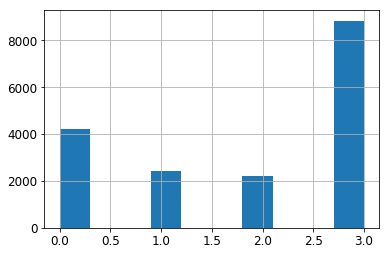

In [41]:
y_lgb_pred = run_lgb_regression(reduce_train, adjusted_test, features, 5)

Fold 1
[0]	train-rmse:1.85648	val-rmse:1.85716
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	train-rmse:1.03027	val-rmse:1.16845
[200]	train-rmse:0.759243	val-rmse:1.02936
[300]	train-rmse:0.653274	val-rmse:1.00727
[400]	train-rmse:0.597511	val-rmse:1.00557
Stopping. Best iteration:
[347]	train-rmse:0.623526	val-rmse:1.00523

Fold 2
[0]	train-rmse:1.85648	val-rmse:1.85747
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.04078	val-rmse:1.16499
[200]	train-rmse:0.778846	val-rmse:1.02199
[300]	train-rmse:0.674753	val-rmse:0.998062
[400]	train-rmse:0.618534	val-rmse:0.992837
[500]	train-rmse:0.578164	val-rmse:0.991738
[600]	train-rmse:0.544472	val-rmse:0.991681
[700]	train-rmse:0.518892	val-rmse:0.991683
Stopping. Best iteration:
[668]	train-rmse:0.525841	val-rmse:0.991289

Fold 3
[0]	train-rmse:1.85644	val-rmse:1.85756
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]

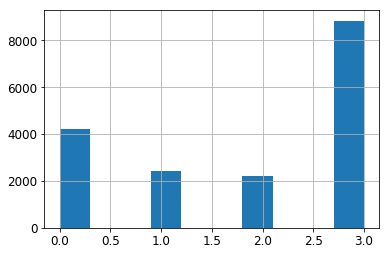

In [42]:
y_xgb_pred = run_xgb_regression(reduce_train, adjusted_test, features, 5)

In [43]:
lgb_weight = 0.7
final_pred = y_lgb_pred * lgb_weight + y_xgb_pred * (1 - lgb_weight)
print(final_pred.shape, y_lgb_pred.shape, y_xgb_pred.shape)

(1000,) (1000,) (1000,)


{0: 1.3746859092620616, 1: 1.6792663912138355, 2: 1.896572498502405}


3    0.500
0    0.239
1    0.136
2    0.125
Name: accuracy_group, dtype: float64

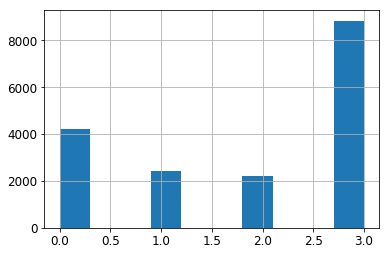

In [44]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))

sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index = False)
sample_submission['accuracy_group'].value_counts(normalize = True)